# Instalar dependências

In [1]:
!pip install -q torch torchvision albumentations kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.8 MB/s eta 0:00:00


#  Upload do kaggle.json

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"luisthedevmagician","key":"c47963d0936c6df20a8ee23348fa030f"}'}

#  Configurar Kaggle e Baixar e extrair o dataset WIDER Face (formato YOLO)

In [3]:

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


!kaggle datasets download -d lylmsc/wider-face-for-yolo-training
!unzip -q wider-face-for-yolo-training.zip -d wider_face

Dataset URL: https://www.kaggle.com/datasets/lylmsc/wider-face-for-yolo-training
License(s): CC0-1.0
100% 2.44G/2.45G [00:05<00:00, 75.9MB/s]
100% 2.45G/2.45G [00:05<00:00, 502MB/s] 


#  Reorganizar diretórios: train/val split

In [4]:
import os
from pathlib import Path
import shutil
from sklearn.model_selection import train_test_split

base = Path("wider_face")
if not (base/"images/train").exists():
    os.makedirs(base/"images/train", exist_ok=True)
    os.makedirs(base/"images/val", exist_ok=True)
    os.makedirs(base/"labels/train", exist_ok=True)
    os.makedirs(base/"labels/val", exist_ok=True)

    all_images = list((base/"images").glob("*.jpg"))
    train_imgs, val_imgs = train_test_split(all_images, test_size=0.2, random_state=42)

    for img in train_imgs:
        shutil.move(str(img), base/"images/train"/img.name)
        label = base/"labels"/img.with_suffix('.txt').name
        if Path(label).exists():
            shutil.move(str(label), base/"labels/train"/Path(label).name)

    for img in val_imgs:
        shutil.move(str(img), base/"images/val"/img.name)
        label = base/"labels"/img.with_suffix('.txt').name
        if Path(label).exists():
            shutil.move(str(label), base/"labels/val"/Path(label).name)

#  Dataset personalizado para WIDER Face em formato YOLO

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import cv2
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

class WIDERFaceDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transforms=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transforms = transforms

        self.images = sorted(os.listdir(images_dir))
        self.valid_images = []

        for img_name in self.images:
            label_path = os.path.join(labels_dir, img_name.replace('.jpg', '.txt'))
            if not os.path.exists(label_path):
                continue

            with open(label_path) as f:
                valid = False
                for line in f:
                    cls, x, y, bw, bh = map(float, line.strip().split())
                    if bw > 0 and bh > 0:
                        valid = True
                        break
                if valid:
                    self.valid_images.append(img_name)

    def __getitem__(self, idx):
        img_name = self.valid_images[idx]
        img_path = os.path.join(self.images_dir, img_name)
        label_path = os.path.join(self.labels_dir, img_name.replace('.jpg', '.txt'))

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]

        boxes = []
        if os.path.exists(label_path):
            with open(label_path) as f:
                for line in f:
                    cls, x, y, bw, bh = map(float, line.strip().split())
                    x_min = (x - bw / 2) * w
                    y_min = (y - bh / 2) * h
                    x_max = (x + bw / 2) * w
                    y_max = (y + bh / 2) * h
                    if x_max > x_min and y_max > y_min:
                        boxes.append([x_min, y_min, x_max, y_max])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx])
        }

        if self.transforms:
            img = self.transforms(image=img)["image"]

        return img, target

    def __len__(self):
        return len(self.valid_images)

#  Transforms e DataLoaders

In [6]:
transform = A.Compose([
    A.Resize(640, 640),
    A.Normalize(),
    ToTensorV2()
])

train_dataset = WIDERFaceDataset(
    images_dir="wider_face/images/train",
    labels_dir="wider_face/labels/train",
    transforms=transform
)
val_dataset = WIDERFaceDataset(
    images_dir="wider_face/images/val",
    labels_dir="wider_face/labels/val",
    transforms=transform
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

#  Modelo Faster R-CNN com backbone ResNet-50

In [7]:
model = fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 136MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

#  Treinamento

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 7

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for imgs, targets in tqdm(train_loader):
        imgs = list(img.to(device) for img in imgs)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        running_loss += losses.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}")

100%|██████████| 2576/2576 [07:03<00:00,  6.08it/s]


Epoch [1/7], Loss: 10050.3682


100%|██████████| 2576/2576 [07:01<00:00,  6.10it/s]


Epoch [2/7], Loss: 9427.8486


100%|██████████| 2576/2576 [07:01<00:00,  6.11it/s]


Epoch [3/7], Loss: 9291.7266


100%|██████████| 2576/2576 [07:00<00:00,  6.12it/s]


Epoch [4/7], Loss: 9136.8855


100%|██████████| 2576/2576 [07:01<00:00,  6.12it/s]


Epoch [5/7], Loss: 8969.6890


100%|██████████| 2576/2576 [07:01<00:00,  6.11it/s]


Epoch [6/7], Loss: 8928.5488


100%|██████████| 2576/2576 [07:01<00:00,  6.12it/s]

Epoch [7/7], Loss: 8785.6995


#  Avaliação

In [30]:
import matplotlib.pyplot as plt
from torchvision.ops import box_iou
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

def evaluate_model(model, dataloader, iou_threshold=0.5, score_threshold=0.5):
    model.eval()
    all_preds = []
    all_targets = []

    for imgs, targets in dataloader:
        imgs = [img.to(device) for img in imgs]
        with torch.no_grad():
            outputs = model(imgs)

        for i in range(len(outputs)):
            pred_boxes = outputs[i]['boxes'].cpu()
            pred_scores = outputs[i]['scores'].cpu()
            pred_labels = outputs[i]['labels'].cpu()

            gt_boxes = targets[i]['boxes']
            gt_labels = targets[i]['labels']

            # Filtrar boxes com score baixo
            keep = pred_scores > score_threshold
            pred_boxes = pred_boxes[keep]

            matched_gt = set()
            matched_pred = set()

            if len(pred_boxes) > 0 and len(gt_boxes) > 0:
                ious = box_iou(pred_boxes, gt_boxes)

                for pred_idx in range(ious.size(0)):
                    max_iou, gt_idx = ious[pred_idx].max(0)
                    if max_iou > iou_threshold and gt_idx.item() not in matched_gt:
                        all_preds.append(1)
                        all_targets.append(1)
                        matched_gt.add(gt_idx.item())
                        matched_pred.add(pred_idx)

            for j in range(len(gt_boxes)):
                if j not in matched_gt:
                    all_preds.append(0)
                    all_targets.append(1)

            for j in range(len(pred_boxes)):
                if j not in matched_pred:
                    all_preds.append(1)
                    all_targets.append(0)

    # Métricas
    precision = precision_score(all_targets, all_preds)
    recall = recall_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds)
    cm = confusion_matrix(all_targets, all_preds)

    # Impressão textual
    print("📊 Métricas de Avaliação:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"\nConfusion Matrix:\n{cm}")

    # Plot da matriz de confusão
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Negativo (0)', 'Positivo (1)'],
                yticklabels=['Negativo (0)', 'Positivo (1)'])
    plt.xlabel("Predição")
    plt.ylabel("Valor Real")
    plt.title("📌 Matriz de Confusão")

    # Plot das métricas
    plt.figure(figsize=(6, 4))
    bars = plt.bar(["Precision", "Recall", "F1 Score"], [precision, recall, f1], color=['#4CAF50', '#2196F3', '#FFC107'])
    plt.ylim(0, 1)
    plt.title("📈 Métricas de Desempenho")
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f"{yval:.2f}", ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


📊 Métricas de Avaliação:
Precision: 0.1406
Recall:    0.0074
F1 Score:  0.0140

Confusion Matrix:
[[    0  1595]
 [35173   261]]


/tmp/ipython-input-30-311958267.py:83: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


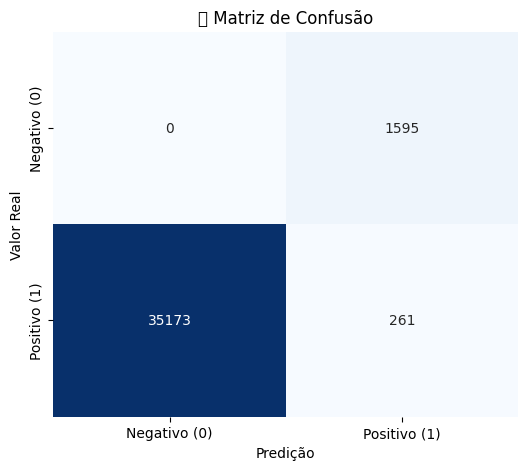

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


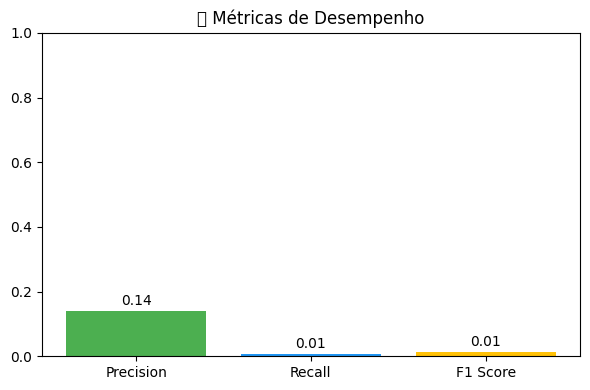

In [31]:
evaluate_model(model, val_loader, iou_threshold=0.5, score_threshold=0.5)


# Verificando Imagens

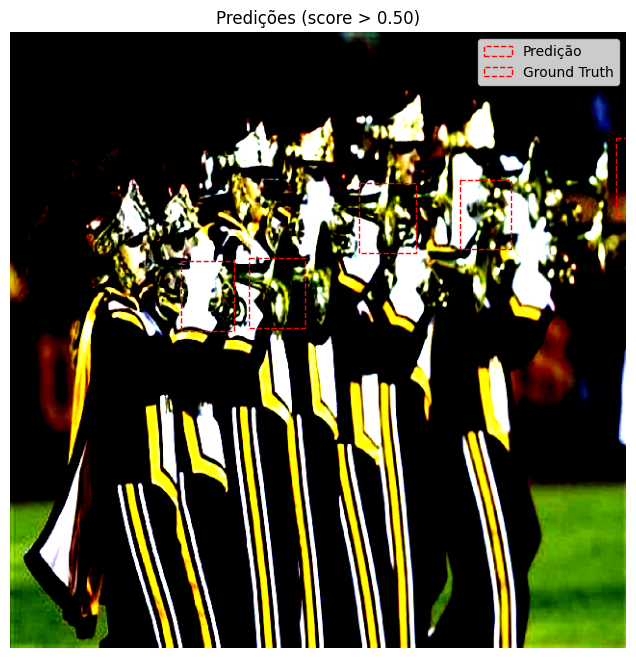

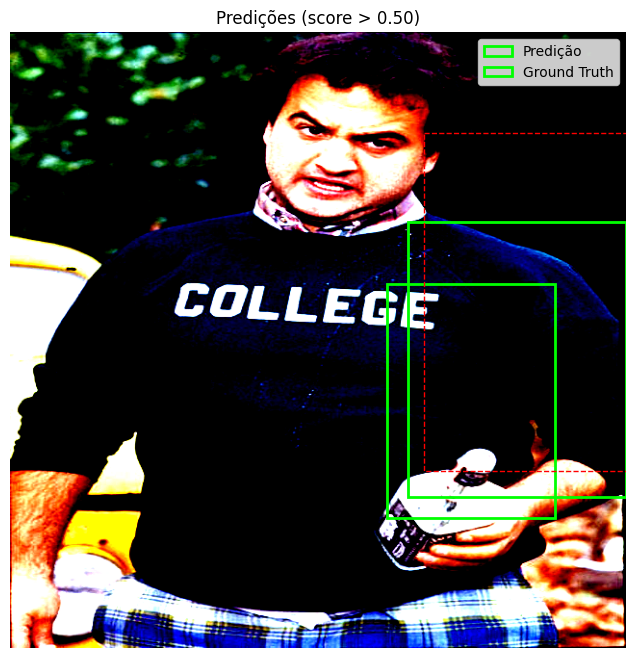

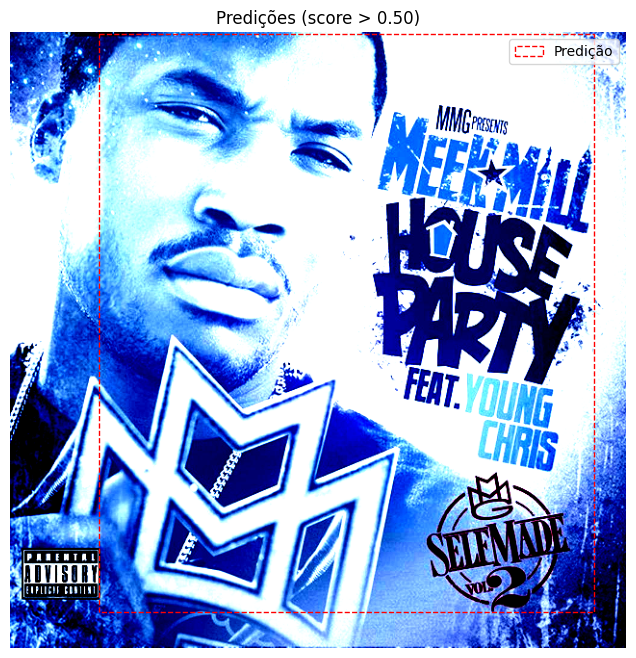

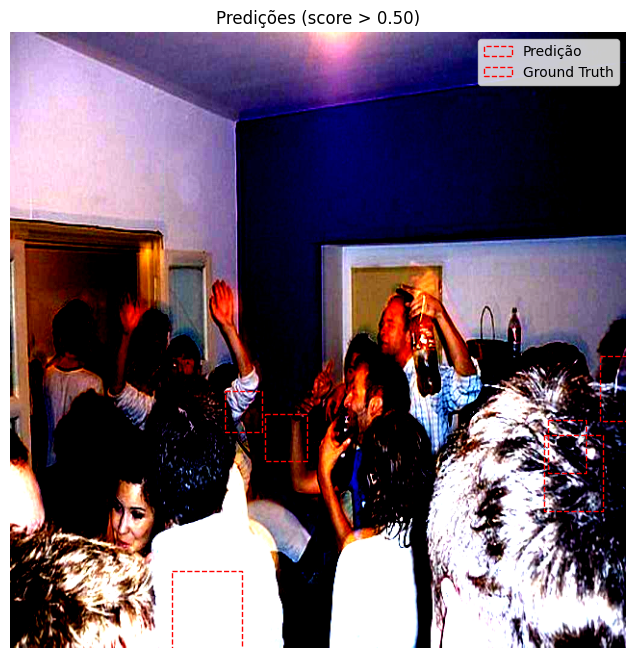

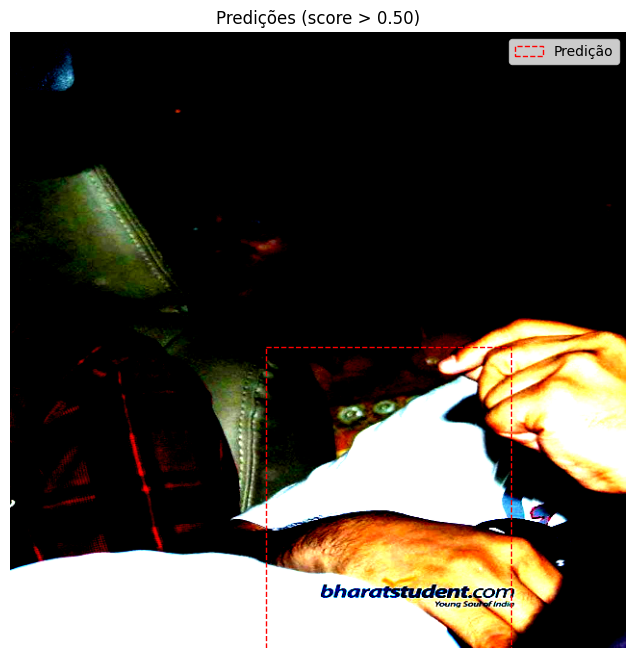

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_predictions(model, dataloader, num_images=5, score_threshold=0.5, show_gt=True):
    model.eval()
    imgs_shown = 0

    for imgs, targets in dataloader:
        imgs = [img.to(device) for img in imgs]
        with torch.no_grad():
            outputs = model(imgs)

        for i in range(len(imgs)):
            img = imgs[i].permute(1, 2, 0).cpu().numpy()
            pred_boxes = outputs[i]['boxes'].detach().cpu()
            scores = outputs[i]['scores'].detach().cpu()

            # Filtrar por score
            keep = scores > score_threshold
            pred_boxes = pred_boxes[keep]
            scores = scores[keep]

            fig, ax = plt.subplots(1, figsize=(8, 8))
            ax.imshow(img)
            ax.set_title(f"Predições (score > {score_threshold:.2f})")

            # Desenha predições
            for box in pred_boxes:
                x1, y1, x2, y2 = box
                rect = patches.Rectangle(
                    (x1, y1), x2 - x1, y2 - y1,
                    linewidth=2, edgecolor='lime', facecolor='none'
                )
                ax.add_patch(rect)

            # Desenha ground truths (opcional)
            if show_gt:
                for gt_box in targets[i]['boxes']:
                    x1, y1, x2, y2 = gt_box
                    rect = patches.Rectangle(
                        (x1, y1), x2 - x1, y2 - y1,
                        linewidth=1, edgecolor='red', facecolor='none', linestyle='--'
                    )
                    ax.add_patch(rect)
                ax.legend(["Predição", "Ground Truth"], loc="upper right")

            plt.axis("off")
            plt.show()

            imgs_shown += 1
            if imgs_shown >= num_images:
                return


plot_predictions(model, val_loader, num_images=5, score_threshold=0.5)
